In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader, Dataset, random_split

1. Our date here is csv file

In [26]:
df = pd.read_csv('./data/regresion_data.csv')
df = df.drop(columns='Unnamed: 0')
# there is no frq if there are no aerodnamic circuit => 
# => if label != 1.
# then
index_names = df[(df['label'] == 0)].index
df.drop(index_names, inplace = True)
# Also, after that segregation by the label, we can drop label column
df = df.drop(columns='label')
print(df.head(10))

   axial_max   tang_max  index_of_axm  index_of_tnm  axial_in_mxt   
0 -16.549675 -17.654378            28            48    -10.975493  \
1 -16.564726 -17.815883            28            52    -14.410172   
2 -16.335568 -17.578816            28            50    -12.664116   
3 -15.968865 -17.108087            28            47    -10.236513   
4 -15.227270 -16.266240            28            49    -12.056063   
5 -14.682051 -15.377140            27            51    -13.252567   
6 -14.086215 -14.515554            27            50    -12.391912   
7 -13.962619 -13.729980            28            45     -9.941273   
8 -13.620183 -13.183838            27            44     -9.637045   
9 -12.883969 -11.235115            24            41     -8.141471   

   tang_in_mxa  cone_angl   frequancy  
0   -16.597827          4  126.984123  
1   -16.724255          4  126.984123  
2   -16.415995          4  125.152626  
3   -15.878571          4  120.879120  
4   -15.246275          4  114.774117  


In [27]:
df.corr()

,axial_max,tang_max,index_of_axm,index_of_tnm,axial_in_mxt,tang_in_mxa,cone_angl,frequancy
axial_max,1.000000,0.900749,-0.729426,-0.752424,0.602443,0.899512,0.213329,-0.883728
tang_max,0.900749,1.000000,-0.804928,-0.780352,0.524339,0.979297,0.144075,-0.931279
index_of_axm,-0.729426,-0.804928,1.000000,0.613799,-0.345900,-0.759659,-0.084282,0.740377
index_of_tnm,-0.752424,-0.780352,0.613799,1.000000,-0.899130,-0.836412,-0.228411,0.751852
axial_in_mxt,0.602443,0.524339,-0.345900,-0.899130,1.000000,0.594057,0.247548,-0.480937
tang_in_mxa,0.899512,0.979297,-0.759659,-0.836412,0.594057,1.000000,0.175369,-0.944057
cone_angl,0.213329,0.144075,-0.084282,-0.228411,0.247548,0.175369,1.000000,-0.074179
frequancy,-0.883728,-0.931279,0.740377,0.751852,-0.480937,-0.944057,-0.074179,1.000000


<Axes: >

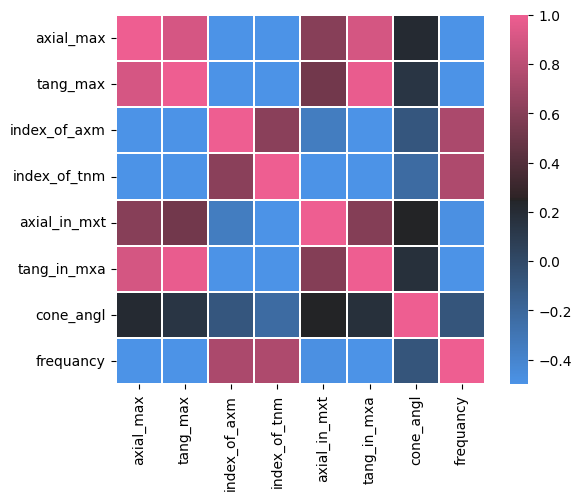

In [30]:
# check of independense

# Lets build something to visualise undepandance od data features
corr = df.iloc[:,:].corr(method='pearson')
cmap = sns.diverging_palette(250, 354, 80, 60, center = 'dark', as_cmap = True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

2. Let's try with not full data

In [32]:
df_first_modl = df[['tang_max', 'tang_in_mxa', 'frequancy']]

print(df_first_modl.shape)

(492, 3)


In [34]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

def tensor_for_model(df, num_item, num_row) -> torch.tensor:

    features = torch.tensor(np.random.normal(0, 1, (num_row, num_item)), dtype=torch.float)
    print(features)
    #for col in range
    return features

features = tensor_for_model(df_first_modl, df_first_modl.shape[1] - 1, df_first_modl.shape[0])
label = np.ndarray(df_first_modl['frequancy'], dtype=np.float32)

tensor([[ 1.0384e+00,  1.7354e-01],
        [-9.5288e-01,  7.3541e-01],
        [-7.4245e-01, -3.1086e+00],
        [ 1.2461e+00,  3.4457e-01],
        [ 4.3180e-01, -2.0040e+00],
        [ 3.9269e-01,  4.2215e-01],
        [ 1.7938e+00,  8.2331e-01],
        [-4.4144e-01, -1.2397e-01],
        [ 1.9561e+00,  5.6270e-01],
        [-1.1106e+00, -2.7406e-01],
        [-9.1601e-01, -5.9121e-01],
        [-4.0959e-01, -6.4723e-01],
        [ 2.7122e-01,  4.4749e-01],
        [-3.9735e-01,  3.5779e-01],
        [-4.0810e-01,  5.2088e-01],
        [ 1.3144e+00, -1.7311e-01],
        [-1.8042e+00,  1.4956e+00],
        [-6.5066e-01, -1.9934e-01],
        [ 8.4986e-01,  1.8980e-01],
        [-1.3251e+00, -1.4841e-01],
        [-8.8191e-01, -5.5912e-01],
        [ 4.2571e-01,  3.5205e-02],
        [-6.6839e-01, -3.2349e-01],
        [ 7.7762e-01, -6.8479e-01],
        [ 1.0527e+00,  5.8828e-01],
        [ 1.4372e+00,  1.1138e+00],
        [-1.6993e-01,  4.0880e-01],
        [ 1.4294e+00, -9.809

ValueError: maximum supported dimension for an ndarray is 32, found 492

In [ ]:
# Define a Dataset
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.from_numpy(X_numpy.astype('float32'))
        self.y = torch.from_numpy(y_numpy.astype('float32'))

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index].unsqueeze(0)
    
dataset = RegressionDataset(X_numpy, y_numpy)

NameError: name 'X_numpy' is not defined